In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import pickle
from collections import namedtuple, defaultdict
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange, tqdm_notebook
import torch.nn as nn
from radam import RAdam
from torch.optim import Adam
import torch.nn.functional as F
from tensorboardX import SummaryWriter
#SummaryWriter encapsulates everything
exp_name = 'exp-2-LNN_V1'
writer = SummaryWriter(f"pnet/{exp_name}")

torch.manual_seed(1233)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
#assert device =='cuda'


TradingEpisode = namedtuple('TradingEpisode', ['prices', 'features'])
EPS=1e-5

In [19]:
mprms = dict(
    epi_length=3000,
    epi_test_length=10_000,
    batch_size = 128,
    hid_size= 512,
    learning_rate = 1e-3,
    epoches = 5,
    alpha = 0.05)


CONFIG = mprms
passport = dict(group = 'Base_1',tags = ['sa'],project_name = 'Zero_Test')

In [3]:
f_multiplier = 1_000_000
class MeanReversionSet(torch.utils.data.Dataset):
    def __init__(self, features, prices, epi_len):
        super().__init__()
        self.features = features
        self.prices = prices
        self.epi_len = epi_len
        self.num_ticks = len(features)
    def __getitem__(self, i):
        features = torch.as_tensor(f_multiplier*self.features[i:i+self.epi_len] , dtype = torch.float32)
        prices   = torch.as_tensor(self.prices  [i:i+self.epi_len] , dtype = torch.float32)
        return TradingEpisode(prices = prices, features = features)
    def __len__(self):
        return self.num_ticks - self.epi_len

In [4]:
class Strategy_NN:
    def __init__(self):
        self.MLAlgorithm = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.mprms = dict(
            epi_length=3000,
            epi_test_length=10_000,
            batch_size = 128,
            hid_size= 512,
            learning_rate = 1e-3)
        #self.test_features = None
        #self.train_features = None

    def setMLAlgorithm(self, ML): # CAN BE CHANGED, BUT WE DON'T ADVISE TO DO THAT
        self.MLAlgorithm = ML

    def dataPreparation(self, DP,MRPRMS = None, start_point = 0.7): 
        device = self.device
        mprms = MRPRMS
        if mprms == None:
            mprms = self.mprms
        
        features = pd.DataFrame(dict(px = DP)).assign(
        dpx1 = lambda x: x.px - x.px.ewm(64).mean(),
        dpx2 = lambda x: x.px.ewm(64).mean() - x.px.ewm(128).mean(),
        dpx3 = lambda x: x.px.ewm(128).mean() - x.px.ewm(256).mean(),
        dpx4 = lambda x: x.px.ewm(256).mean() - x.px.ewm(512).mean())
       # split_idx = int(features.shape[0]*0.7)
       # self.train_features = features[:split_idx]
       # self.test_features = features[split_idx:]
        
        split_idx = int(features.shape[0]*start_point)
        f_features = features[split_idx:].filter(like = 'dp').values
        
        dataset = MeanReversionSet(f_features, features['px'].values, epi_len = mprms['epi_length'])
        mkt_loader = torch.utils.data.DataLoader(dataset, batch_size=mprms['batch_size'], shuffle=True, num_workers=4)
        n_features = f_features.shape[1]
        
        mkte = next(iter(mkt_loader))
        mkte = TradingEpisode(*map(lambda x: x.to(device), mkte))
        
        

        return mkte.features
    
    
    def getPosition(self, DP):
        X = self.dataPreparation(DP)
        Y = self.MLAlgorithm(X[:,0,:])
        for t in range(1,X.shape[1]):
            act = self.MLAlgorithm(X[:,t,:])
            Y = torch.cat((Y,act),0)
        return Y

    def serialize(self, fileName): # do NOT ever change or remove it!!!
        type_data = pickle.dumps(Strategy)# <= DEFINE YOUR OWN TYPE!!!!!!!
        self_data = pickle.dumps(self)
        with open(fileName, 'wb') as f:
            pickle.dump((type_data, self_data), f)

In [5]:
with open('from_mansur.pck', 'rb') as f:
    comp = pickle.load(f)
comp = comp[:70000]
split_idx = int(comp.shape[0]*0.7)
train_comp = comp[:split_idx]
test_comp = comp[split_idx:]

In [6]:
class PrtfNNLin(nn.Module):
    """ A neural network that generates signals """

    def __init__(self, num_features, hid_size=mprms['hid_size'], tau=0.5):
        super().__init__()
        self.L1 = nn.Linear(num_features, hid_size)
        self.L1A = nn.Tanh()
        self.hid_to_actions = nn.Linear(hid_size, 3)
        self.tau = tau
        self.hard = False
    def forward(self, inp_features):
        l2 = self.L1(inp_features) 
        #print(l2.shape)        
        l2a = self.L1A(l2)
        action_seq = self.hid_to_actions( l2a )
        final_actions = torch.nn.functional.gumbel_softmax(action_seq, hard=self.hard, tau=self.tau)
        return final_actions

In [20]:
def setup_experiment(config, comp):
    # Make the data
    
    
    features = pd.DataFrame(dict(px = comp)).assign(
    dpx1 = lambda x: x.px - x.px.ewm(64).mean(),
    dpx2 = lambda x: x.px.ewm(64).mean() - x.px.ewm(128).mean(),
    dpx3 = lambda x: x.px.ewm(128).mean() - x.px.ewm(256).mean(),
    dpx4 = lambda x: x.px.ewm(256).mean() - x.px.ewm(512).mean())

    
    split_idx = int(comp.shape[0]*0.7)
    train_comp = comp[:split_idx]
    test_comp = comp[split_idx:]
    
    train_features = pd.DataFrame(dict(px = train_comp)).assign(
    dpx1 = lambda x: x.px - x.px.ewm(64).mean(),
    dpx2 = lambda x: x.px.ewm(64).mean() - x.px.ewm(128).mean(),
    dpx3 = lambda x: x.px.ewm(128).mean() - x.px.ewm(256).mean(),
    dpx4 = lambda x: x.px.ewm(256).mean() - x.px.ewm(512).mean())

    test_features = features[split_idx:]
    
    
    
   # train, test = get_data(train=True), get_data(train=False)
    #train_loader = make_loader(train, batch_size=config.batch_size)
    #test_loader = make_loader(test, batch_size=config.batch_size)
    
    f_train_values = train_features.filter(like = 'dp').values
    f_test_values = test_features.filter(like = 'dp').values
    
    dataset = MeanReversionSet(f_train_values, train_features['px'].values, epi_len = mprms['epi_length'])
    mkt_loader = torch.utils.data.DataLoader(dataset, batch_size=mprms['batch_size'], shuffle=True, num_workers=4)
    n_features = f_train_values.shape[1]

    testset = MeanReversionSet(f_test_values, test_features['px'].values, epi_len = mprms['epi_test_length'])
    mkt_tst_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)
    n_test_features = f_test_values.shape[1]
    


    # Make the model
    model = PrtfNNLin(n_features).to(device)
    opt = RAdam(model.parameters(), lr=config['learning_rate'])

    mkte = next(iter(mkt_loader))
    mkte = TradingEpisode(*map(lambda x: x.to(device), mkte))
    zero_state = torch.zeros(config['batch_size'], config['hid_size']).to(device)
    initial_hid = (zero_state, zero_state)  # [h, c]
    # res = model(mkte.features[:,0,:], initial_hid)
    #res = model(mkte.features[:,0,:])
    
    mkte_test = next(iter(mkt_tst_loader))
    mkte_test = TradingEpisode(*map(lambda x: x.to(device), mkte_test))
    zero_state_tst = torch.zeros(1, mprms['hid_size']).to(device)
    initial_hid_tst = (zero_state_tst, zero_state_tst)  # [h, c]    

    
    return model, dataset, testset,  opt, mkte, mkte_test, mkt_loader, mkt_tst_loader

In [21]:
model, dataset, testset,  opt, mkte, mkte_test, mkt_loader, mkt_tst_loader = setup_experiment(CONFIG,comp)

In [15]:
import wandb

In [16]:
wandb.login()

wandb: Currently logged in as: s_artamonov (use `wandb login --relogin` to force relogin)


True

In [27]:
def train_log(loss, sharpe,tau,example_ct, epoch):
    loss = float(loss)

    # where the magic happens
    wandb.log({"epoch": epoch, "train/loss": loss,'train/sharpe' : sharpe}, step=example_ct)
    #print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

def train_val_log(sharpe, mean_R,example_ct, epoch):
    # where the magic happens
    wandb.log({"epoch": epoch, 'val/sharpe' : sharpe,'val/mean_R' : mean_R}, step=example_ct)
   # print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [35]:
def calc_m2m(model,  mkte):
    actions = model(mkte.features)

    new_positions = torch.matmul(torch.tensor([-1,0,1.0]).to(device),actions.permute(0,2,1) )

    new_positions[:, -1] = torch.zeros_like(new_positions[:, -1])

    d_positions = F.pad(new_positions[:,1:] - new_positions[:,:-1], (1,0))

    d_cash = -d_positions* mkte.prices
    #print(d_cash.shape)

    cash = d_cash.sum(-1)
    
    m2m = torch.cumsum( d_cash , dim = -1) + new_positions* mkte.prices
    #print(m2m.shape)
    #print(torch.cummax(m2m, dim=-1))
    m2m_drawdown = torch.cummax(m2m, dim=-1)[0]- m2m
    m2m_drawdown = m2m_drawdown.mean(-1).mean()
   # print(m2m_drawdown.shape)
    
    
    m2m_final = cash
    return m2m_final, cash, new_positions, d_cash, m2m_drawdown, m2m


def calc_episode(model, mkte, add_stat=False):
    stats = defaultdict(list)
    batch_size, n_timestamps, n_features = mkte.features.shape
    zero_state = torch.zeros(batch_size, mprms['hid_size']).to(device)
    initial_hid = (zero_state, zero_state)  # [h, c]
    
#     new_state, actions = model(mkte.features[:,0,:], initial_hid)
    actions = model(mkte.features[:,0,:])

    positions = torch.zeros(batch_size, requires_grad=True).to(device)
    cash = torch.zeros_like(positions, requires_grad=True).to(device)
    m2m  = torch.zeros_like(positions, requires_grad=True).to(device)
    
    for t in range(1, mprms['epi_length']-1):
#         new_state, actions = model(mkte.features[:,t,:], new_state)
        actions = model(mkte.features[:,t,:])
        
        if add_stat:
            stats['t'] = t
            stats['actions'].append(actions.cpu().detach().numpy())
            
        new_positions = torch.matmul(torch.tensor([-1,0,1.0]).to(device),actions.T)
        if add_stat:
            stats['positions'].append(new_positions.cpu().detach().numpy())
        d_positions = new_positions - positions
        d_cash = -d_positions* mkte.prices[:,t]
        cash = cash + d_cash
        new_m2m = cash + new_positions * mkte.prices[:,t]

        if add_stat:
            stats['m2m'].append(new_m2m.cpu().detach().numpy())
        
        positions = new_positions
        m2m=new_m2m
        
    return m2m, cash, positions, stats

def train(model,mkt_loader,config,opt = opt):
    sharpe_max = 0
    t = 0
    l_hist = list()
    n_iter = config['epoches']
    alpha = config['alpha']
    while t < n_iter:
        with tqdm(mkt_loader) as mkt_loader:
            i = -1
            for mkte in mkt_loader:
                i+=1
                mkte = TradingEpisode(*map(lambda x: x.to(device), mkte))
            
                m2m_final, cash, new_positions, d_cash, m2m_drawdown, M2M = calc_m2m(model, mkte)
                mean_ret = m2m_final.mean()
               # print('M2M.shape: {} \nmean_ret: {}'.format(m2m.shape,mean_ret))
                sharpe = mean_ret / (m2m_final.std() + EPS)
                #print(m2m.shape)
                #print(sharpe.shape)
                #loss = -sharpe - alpha*m2m_drawdown     Very Stupid))
                loss = -sharpe + alpha*m2m_drawdown
               #print(loss.shape)
                loss.backward()

                opt.step()

                opt.zero_grad()
                
                train_log(loss.item(),sharpe.item(),model.tau,i,t)
                
               # writer.add_scalar('train/loss', loss.item(), t)
                #writer.add_scalar('train/sharpe', sharpe.item(), t)
                #writer.add_scalar('train/tau', model.tau, t)
            
                l_hist.append(loss.item())
                if t%20==0:
                    with torch.no_grad():
                        m2m_final, cash, positions, d_cash, m2m_drawdown, M2M = calc_m2m(model, mkte_test)
                    R = np.stack(m2m_final.cpu().detach().numpy()).reshape(-1)
                    mean_R = np.mean(R)
                    sharpe = mean_R / (np.std(R) + EPS)
                
                    if sharpe > sharpe_max:
                    
                        torch.save(model, f"pnet/{exp_name}/model_{t}.chk")
                        sharpe_max = sharpe
                    train_val_log(sharpe, mean_R,i, t)
                    #writer.add_scalar('test/sharpe', sharpe, t)
                    #writer.add_scalar('test/mean_R', mean_R, t)
                
                t+=1


In [36]:
def test(model, mkte_test):
    with torch.no_grad():
        m2m, cash, positions, stat = calc_episode(model, mkte_test, True)
    RW = m2m.mean() / (m2m.std() + EPS)
    plt.plot( np.stack(stat['m2m']).T[0,:])

In [37]:
def model_pipeline(hyperparameters, comp):
    # tell wandb to get started
      with wandb.init(project=passport['project_name'], group=passport['group'], tags=passport['tags'], config=hyperparameters, save_code=False):    
#    with wandb.init(config=hyperparameters):

    # access all HPs through wandb.config, so logging matches execution!
          config = wandb.config

      # make the model, data, and optimization problem
          model, dataset, testset,  opt, mkte, mkte_test, mkt_loader, mkt_tst_loader = make(config,comp)
          print(model)

      # and use them to train the model
          train(model,mkt_loader,config,opt)

      # and test its final performance
          test(model, mkte_test)

      return model

wandb: ERROR wandb version 0.10.18.dev1 has been retired!  Please upgrade.
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


PrtfNNLin(
  (L1): Linear(in_features=4, out_features=512, bias=True)
  (L1A): Tanh()
  (hid_to_actions): Linear(in_features=512, out_features=3, bias=True)
)


epoch,359
train/loss,-0.26948
train/sharpe,0.54275
val/sharpe,-3464843.75
val/mean_R,-34.64844
_runtime,251
_timestamp,1614863166
_step,359


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▆█▇▆▆▆▅▄▅▄▃▄▄▄▃▃▃▂▁▃▃▂▂▂▂▃▃▁▁▃▃▂▂▂▂▂▁▁▄
train/sharpe,▂▃▁▂▃▂▂▃▅▄▅▆▅▅▅▅▆▆▇▇▆▆▇▇▇▇▆▆██▆▆▇▇▇▇▇██▅
val/sharpe,█▂█▇▁▇█▄▄█▄▃▄▄▅▅▄▄
val/mean_R,█▂█▇▁▇█▄▄█▄▃▄▄▅▅▄▄
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: ERROR wandb version 0.10.18.dev1 has been retired!  Please upgrade.
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


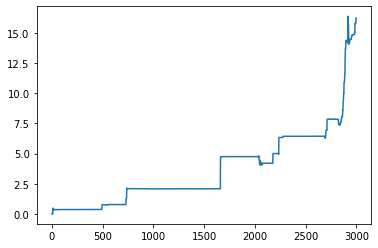

In [38]:
model = model_pipeline(CONFIG, comp)